In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
device_name = tf.test.gpu_device_name() #GPU Run Check
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/splitlabel/'
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/467case_cut/'
os.listdir(DATA_PATH)

['뿌리-부재2.xlsx',
 '크기-나무-크다.xlsx',
 'test_가지-부재.xlsx',
 '위치-나무-정중앙.xlsx',
 'train_위치-나무-정중앙.xlsx',
 '수관-공 모양.xlsx',
 'sub_가지-부재.xlsx',
 '크기-사람-작다.xlsx',
 '위치-사람-정중앙.xlsx',
 'train_위치-나무-아래.xlsx',
 'sub_기둥-상처, 옹이구멍.xlsx',
 'train_뿌리-부재2.xlsx',
 '기둥-옹이구멍 안 동물.xlsx',
 'test_뿌리-부재1.xlsx',
 'train_수관-공 모양.xlsx',
 'sub_위치-나무-위.xlsx',
 '손-정교함(손톱, 주름).xlsx',
 '위치-나무-위.xlsx',
 'train_가지-부재.xlsx',
 '머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 '가지-부재.xlsx',
 '문-격자무늬 창.xlsx',
 '절단-나무-위.xlsx',
 'sub_위치-나무-아래.xlsx',
 'test_절단-나무-오른쪽.xlsx',
 'sub_뿌리-부재1.xlsx',
 'test_위치-나무-아래.xlsx',
 '손-부재.xlsx',
 '창문-많다.xlsx',
 'train_가지-옆으로 벌어짐.xlsx',
 '위치-사람-오른쪽.xlsx',
 'train_기둥-상처, 옹이구멍.xlsx',
 'test_기둥-상처, 옹이구멍.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 'train_크기-나무-크다.xlsx',
 'sub_절단-나무-위.xlsx',
 'sub_가지-아래로 늘어진 가지.xlsx',
 'train_위치-나무-위.xlsx',
 '창문-격자무늬.xlsx',
 'test_절단-나무-위.xlsx',
 '다리-넓게 벌림.xlsx',
 'test_수관-공 모양.xlsx',
 '위치-나무-아래.xlsx',
 '다리-앉아있음.xlsx',
 '위치-집-아래.xlsx',
 'sub_절단-나무-오른쪽.xlsx',
 'sub_기둥-옹이구멍 안 동물.xlsx',
 '가지-아

In [0]:
tree = ['크기-나무-크다',
           '위치-나무-정중앙',
            '위치-나무-아래',
            '위치-나무-위',
            '절단-나무-위',
            '절단-나무-오른쪽',
            '가지-아래로 늘어진 가지',
            # '뿌리-부재1',
            '수관-공 모양',
            '기둥-옹이구멍 안 동물',
            '가지-부재',
            '뿌리-부재2',
            '가지-옆으로 벌어짐',
            '기둥-상처, 옹이구멍'
            ]

In [0]:
# TRAIN_CROP_PATH = '/Users/Il-hyeon/Documents/Data/train_crop'
TRAIN_IMG_PATH = os.path.join(IMG_PATH, 'tree')

df_train = []
df_test = []
for excel_name in tree:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH, 'train_' + excel_name + '.xlsx')))
    df_train[tree.index(excel_name)]['data'] = df_train[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH, 'test_' + excel_name + '.xlsx')))
    df_test[tree.index(excel_name)]['data'] = df_test[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [7]:
for i in range(len(tree)):
    print(df_train[i].head())
    print(df_test[i].head())

   Unnamed: 0        data  크기-나무-크다
0         174  0200_T.jpg         1
1         272  0317_T.jpg         1
2         170  0196_T.jpg         1
3           8  0009_T.jpg         1
4         214  0245_T.jpg         1
   Unnamed: 0        data  크기-나무-크다
0         433  0502_T.jpg         1
1          71  0072_T.jpg         0
2           7  0008_T.jpg         1
3         352  0421_T.jpg         1
4         444  0513_T.jpg         1
   Unnamed: 0        data  위치-나무-정중앙
0         220  0252_T.jpg          0
1         363  0432_T.jpg          0
2         394  0463_T.jpg          0
3         142  0159_T.jpg          0
4          41  0042_T.jpg          0
   Unnamed: 0        data  위치-나무-정중앙
0         442  0511_T.jpg          0
1         324  0393_T.jpg          0
2         159  0182_T.jpg          0
3         269  0312_T.jpg          0
4         101  0102_T.jpg          0
   Unnamed: 0        data  위치-나무-아래
0         253  0292_T.jpg         0
1         375  0444_T.jpg         1
2          69  0

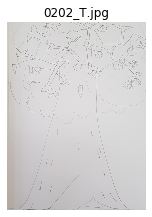

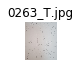

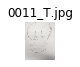

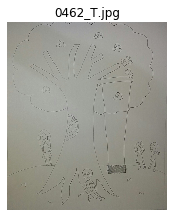

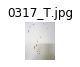

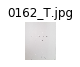

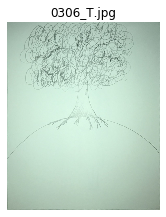

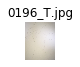

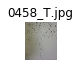

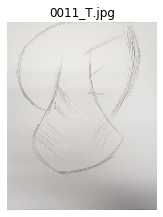

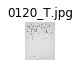

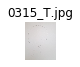

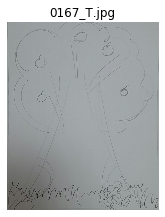

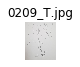

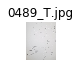

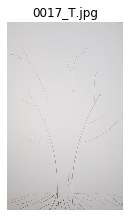

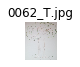

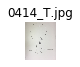

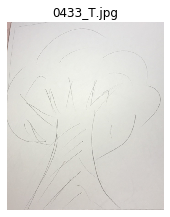

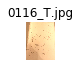

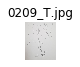

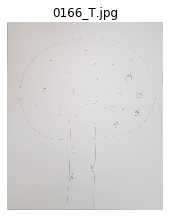

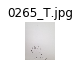

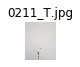

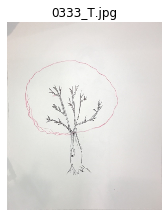

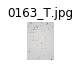

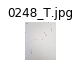

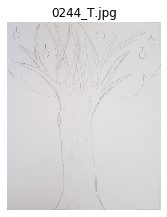

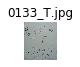

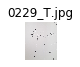

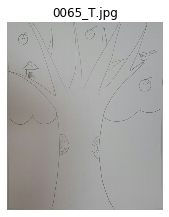

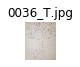

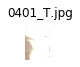

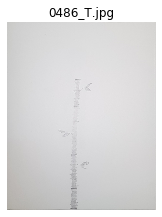

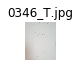

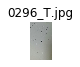

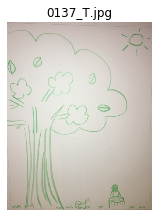

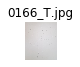

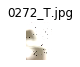

In [8]:
for i in range(len(df_train)):
    tmp_img = df_train[i]['data'][100:103]
    plt.figure(figsize=(12, 20))
    
    for num, f_name in enumerate(tmp_img):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X_train = []
X_val = []

for i, data in enumerate(tree):
    df_train[i][data] = df_train[i][data].astype('str')
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]
    
    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, test_size = 0.2, random_state = 42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])
    
    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print(df_test[i].shape)
    print('='*20)

크기-나무-크다
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-정중앙
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-아래
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-오른쪽
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-아래로 늘어진 가지
(298, 2)
(75, 2)
(373, 2)
(94, 1)
수관-공 모양
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-옹이구멍 안 동물
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-부재
(298, 2)
(75, 2)
(373, 2)
(94, 1)
뿌리-부재2
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-옆으로 벌어짐
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-상처, 옹이구멍
(298, 2)
(75, 2)
(373, 2)
(94, 1)


In [0]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [11]:
epochs = 20
batch_size = 32
img_size = (224, 224)
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False, 
    rotation_range = 3,   # image random roation
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(tree):
        nb_train_samples.append(len(X_train[i]))
        nb_validation_samples.append(len(X_val[i]))
        nb_test_samples.append(len(df_train[i]))
        
        train_generator.append(train_datagen.flow_from_dataframe(
            dataframe=X_train[i],
            directory=TRAIN_IMG_PATH,
            x_col = 'data',
            y_col = tree[i],
            target_size = img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            seed=42
        ))
        
        validation_generator.append(val_datagen.flow_from_dataframe(
            dataframe=X_val[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=tree[i],
            target_size=img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=False
        ))
        
        test_generator.append(test_datagen.flow_from_dataframe(
            dataframe=df_test[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=None,
            target_size = img_size,
            color_mode='rgb',
            class_mode=None,
            batch_size=batch_size,
            shuffle=False
        ))

Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 v

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [13]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax', kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
    
model = MakeMobileModel()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = []

for i in range(len(tree)):
    model = MakeMobileModel()
    filepath = tree[i] + '_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5'
  
    # ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
    ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    
    callbackList = [ckpt]
    
    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = 10,
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 1:31 - loss: 1.3246 - acc: 0.5600
Epoch 00001: val_loss improved from inf to 1.32465, saving model to 크기-나무-크다_mobile_model_0.56_1.3246.h5
10/10 [==============================] - 202s 20s/step - loss: 0.9085 - acc: 0.7013 - val_loss: 1.3246 - val_acc: 0.5600
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 6.4025 - acc: 0.3733
Epoch 00002: val_loss did not improve from 1.32465
10/10 [==============================] - 6s 561ms/step - loss: 0.5269 - acc: 0.8758 - val_loss: 6.4025 - val_acc: 0.3733
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.4925 - acc: 0.7200
Epoch 00003: val_loss did not improve from 1.32465
10/10 [==============================] - 10s 1s/step - loss: 0.3498 - acc: 0.8993 - val_loss: 2.4925 - val_acc: 0.7200
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 3.9689 - acc: 0.5467
Epoch 00004: val_loss did not improve from 1.32465
10/10 [================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 24s - loss: 0.4698 - acc: 0.8000
Epoch 00001: val_loss improved from inf to 0.46978, saving model to 위치-나무-정중앙_mobile_model_0.80_0.4698.h5
10/10 [==============================] - 52s 5s/step - loss: 0.5495 - acc: 0.7886 - val_loss: 0.4698 - val_acc: 0.8000
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5684 - acc: 0.9733
Epoch 00002: val_loss did not improve from 0.46978
10/10 [==============================] - 6s 573ms/step - loss: 0.0174 - acc: 0.9933 - val_loss: 0.5684 - val_acc: 0.9733
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.6532 - acc: 0.9733
Epoch 00003: val_loss did not improve from 0.46978
10/10 [==============================] - 10s 1s/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.6532 - val_acc: 0.9733
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5840 - acc: 0.9733
Epoch 00004: val_loss did not improve from 0.46978
10/10 [==================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 23s - loss: 1.1153 - acc: 0.5938
Epoch 00001: val_loss improved from inf to 1.07471, saving model to 위치-나무-아래_mobile_model_0.57_1.0747.h5
10/10 [==============================] - 27s 3s/step - loss: 0.6271 - acc: 0.7785 - val_loss: 1.0747 - val_acc: 0.5733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.6281 - acc: 0.8800
Epoch 00002: val_loss did not improve from 1.07471
10/10 [==============================] - 6s 576ms/step - loss: 0.1932 - acc: 0.9295 - val_loss: 1.6281 - val_acc: 0.8800
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.7460 - acc: 0.8800
Epoch 00003: val_loss improved from 1.07471 to 0.74600, saving model to 위치-나무-아래_mobile_model_0.88_0.7460.h5
10/10 [==============================] - 11s 1s/step - loss: 0.0971 - acc: 0.9597 - val_loss: 0.7460 - val_acc: 0.8800
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.4488 - acc: 0.8800
Epoch 00004: val_lo

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 21s - loss: 2.2653 - acc: 0.7188
Epoch 00001: val_loss improved from inf to 1.99597, saving model to 위치-나무-위_mobile_model_0.73_1.9960.h5
10/10 [==============================] - 28s 3s/step - loss: 1.0163 - acc: 0.6644 - val_loss: 1.9960 - val_acc: 0.7333
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.3436 - acc: 0.5467
Epoch 00002: val_loss improved from 1.99597 to 1.34356, saving model to 위치-나무-위_mobile_model_0.55_1.3436.h5
10/10 [==============================] - 6s 601ms/step - loss: 0.5859 - acc: 0.8557 - val_loss: 1.3436 - val_acc: 0.5467
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 11.4282 - acc: 0.2667
Epoch 00003: val_loss did not improve from 1.34356
10/10 [==============================] - 10s 1s/step - loss: 0.2643 - acc: 0.9060 - val_loss: 11.4282 - val_acc: 0.2667
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 4.2390 - acc: 0.3467
Epoch 00004: val_lo

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 25s - loss: 0.6972 - acc: 0.7656
Epoch 00001: val_loss improved from inf to 0.75531, saving model to 절단-나무-위_mobile_model_0.73_0.7553.h5
10/10 [==============================] - 30s 3s/step - loss: 1.0811 - acc: 0.6376 - val_loss: 0.7553 - val_acc: 0.7333
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.5621 - acc: 0.4800
Epoch 00002: val_loss did not improve from 0.75531
10/10 [==============================] - 6s 561ms/step - loss: 0.4193 - acc: 0.8792 - val_loss: 2.5621 - val_acc: 0.4800
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.9349 - acc: 0.5600
Epoch 00003: val_loss did not improve from 0.75531
10/10 [==============================] - 10s 1s/step - loss: 0.2301 - acc: 0.9195 - val_loss: 1.9349 - val_acc: 0.5600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 6.6509 - acc: 0.4667
Epoch 00004: val_loss did not improve from 0.75531
10/10 [====================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 24s - loss: 4.6129 - acc: 0.7188
Epoch 00001: val_loss improved from inf to 5.70643, saving model to 절단-나무-오른쪽_mobile_model_0.69_5.7064.h5
10/10 [==============================] - 31s 3s/step - loss: 1.0657 - acc: 0.6174 - val_loss: 5.7064 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 6.5786 - acc: 0.6933
Epoch 00002: val_loss did not improve from 5.70643
10/10 [==============================] - 6s 576ms/step - loss: 0.3326 - acc: 0.8725 - val_loss: 6.5786 - val_acc: 0.6933
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 11.9905 - acc: 0.6933
Epoch 00003: val_loss did not improve from 5.70643
10/10 [==============================] - 10s 1s/step - loss: 0.1186 - acc: 0.9530 - val_loss: 11.9905 - val_acc: 0.6933
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 12.5957 - acc: 0.6933
Epoch 00004: val_loss did not improve from 5.70643
10/10 [===============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 28s - loss: 0.4763 - acc: 0.9844     
Epoch 00001: val_loss improved from inf to 0.31751, saving model to 가지-아래로 늘어진 가지_mobile_model_0.99_0.3175.h5
10/10 [==============================] - 35s 3s/step - loss: 0.1846 - acc: 0.9597 - val_loss: 0.3175 - val_acc: 0.9867
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3591 - acc: 0.9867
Epoch 00002: val_loss did not improve from 0.31751
10/10 [==============================] - 6s 589ms/step - loss: 0.0070 - acc: 0.9966 - val_loss: 0.3591 - val_acc: 0.9867
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3291 - acc: 0.9867
Epoch 00003: val_loss did not improve from 0.31751
10/10 [==============================] - 11s 1s/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.3291 - val_acc: 0.9867
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3089 - acc: 0.9867
Epoch 00004: val_loss improved from 0.31751 to 0.30894, saving mode

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 18s - loss: 0.2193 - acc: 0.9600
Epoch 00001: val_loss improved from inf to 0.21931, saving model to 수관-공 모양_mobile_model_0.96_0.2193.h5
10/10 [==============================] - 37s 4s/step - loss: 0.5267 - acc: 0.7886 - val_loss: 0.2193 - val_acc: 0.9600
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5905 - acc: 0.9600
Epoch 00002: val_loss did not improve from 0.21931
10/10 [==============================] - 6s 573ms/step - loss: 0.1511 - acc: 0.9530 - val_loss: 0.5905 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3453 - acc: 0.9600
Epoch 00003: val_loss did not improve from 0.21931
10/10 [==============================] - 11s 1s/step - loss: 0.1889 - acc: 0.9631 - val_loss: 0.3453 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2829 - acc: 0.8667
Epoch 00004: val_loss did not improve from 0.21931
10/10 [====================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 19s - loss: 0.7509 - acc: 0.9600
Epoch 00001: val_loss improved from inf to 0.75093, saving model to 기둥-옹이구멍 안 동물_mobile_model_0.96_0.7509.h5
10/10 [==============================] - 40s 4s/step - loss: 0.2238 - acc: 0.9430 - val_loss: 0.7509 - val_acc: 0.9600
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5427 - acc: 0.9600
Epoch 00002: val_loss improved from 0.75093 to 0.54274, saving model to 기둥-옹이구멍 안 동물_mobile_model_0.96_0.5427.h5
10/10 [==============================] - 6s 611ms/step - loss: 0.0817 - acc: 0.9799 - val_loss: 0.5427 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.7706 - acc: 0.9600
Epoch 00003: val_loss did not improve from 0.54274
10/10 [==============================] - 10s 1s/step - loss: 0.0446 - acc: 0.9832 - val_loss: 0.7706 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.9725 - acc: 0.9600
Epoch 00004

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 20s - loss: 3.7728 - acc: 0.3200
Epoch 00001: val_loss improved from inf to 3.77281, saving model to 가지-부재_mobile_model_0.32_3.7728.h5
10/10 [==============================] - 42s 4s/step - loss: 0.5634 - acc: 0.8490 - val_loss: 3.7728 - val_acc: 0.3200
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3849 - acc: 0.9067
Epoch 00002: val_loss improved from 3.77281 to 0.38494, saving model to 가지-부재_mobile_model_0.91_0.3849.h5
10/10 [==============================] - 6s 617ms/step - loss: 0.1293 - acc: 0.9530 - val_loss: 0.3849 - val_acc: 0.9067
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.6735 - acc: 0.8933
Epoch 00003: val_loss did not improve from 0.38494
10/10 [==============================] - 10s 1s/step - loss: 0.1869 - acc: 0.9396 - val_loss: 0.6735 - val_acc: 0.8933
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.6103 - acc: 0.8133
Epoch 00004: val_loss did

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 22s - loss: 11.7404 - acc: 0.4533
Epoch 00001: val_loss improved from inf to 11.74042, saving model to 뿌리-부재2_mobile_model_0.45_11.7404.h5
10/10 [==============================] - 46s 5s/step - loss: 0.8853 - acc: 0.6711 - val_loss: 11.7404 - val_acc: 0.4533
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.4089 - acc: 0.5333
Epoch 00002: val_loss improved from 11.74042 to 2.40890, saving model to 뿌리-부재2_mobile_model_0.53_2.4089.h5
10/10 [==============================] - 6s 633ms/step - loss: 0.4638 - acc: 0.8792 - val_loss: 2.4089 - val_acc: 0.5333
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.9231 - acc: 0.6000
Epoch 00003: val_loss improved from 2.40890 to 0.92310, saving model to 뿌리-부재2_mobile_model_0.60_0.9231.h5
10/10 [==============================] - 11s 1s/step - loss: 0.1138 - acc: 0.9497 - val_loss: 0.9231 - val_acc: 0.6000
Epoch 4/20
 3/10 [========>.....................] -

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 24s - loss: 0.7189 - acc: 0.7733
Epoch 00001: val_loss improved from inf to 0.71894, saving model to 가지-옆으로 벌어짐_mobile_model_0.77_0.7189.h5
10/10 [==============================] - 48s 5s/step - loss: 0.7959 - acc: 0.7651 - val_loss: 0.7189 - val_acc: 0.7733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.7033 - acc: 0.7467
Epoch 00002: val_loss improved from 0.71894 to 0.70333, saving model to 가지-옆으로 벌어짐_mobile_model_0.75_0.7033.h5
10/10 [==============================] - 6s 628ms/step - loss: 0.1832 - acc: 0.9396 - val_loss: 0.7033 - val_acc: 0.7467
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.6031 - acc: 0.8400
Epoch 00003: val_loss improved from 0.70333 to 0.60308, saving model to 가지-옆으로 벌어짐_mobile_model_0.84_0.6031.h5
10/10 [==============================] - 11s 1s/step - loss: 0.0967 - acc: 0.9631 - val_loss: 0.6031 - val_acc: 0.8400
Epoch 4/20
 3/10 [========>.................

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 44s - loss: 4.5726 - acc: 0.4844 
Epoch 00001: val_loss improved from inf to 4.28371, saving model to 기둥-상처, 옹이구멍_mobile_model_0.49_4.2837.h5
10/10 [==============================] - 51s 5s/step - loss: 1.1495 - acc: 0.6007 - val_loss: 4.2837 - val_acc: 0.4933
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 12.8567 - acc: 0.4800
Epoch 00002: val_loss did not improve from 4.28371
10/10 [==============================] - 6s 582ms/step - loss: 0.4720 - acc: 0.8523 - val_loss: 12.8567 - val_acc: 0.4800
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 5.4500 - acc: 0.5333
Epoch 00003: val_loss did not improve from 4.28371
10/10 [==============================] - 11s 1s/step - loss: 0.2027 - acc: 0.9430 - val_loss: 5.4500 - val_acc: 0.5333
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.5600 - acc: 0.7600
Epoch 00004: val_loss improved from 4.28371 to 1.56001, saving model to

크기-나무-크다


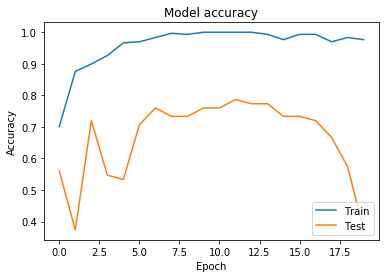

위치-나무-정중앙


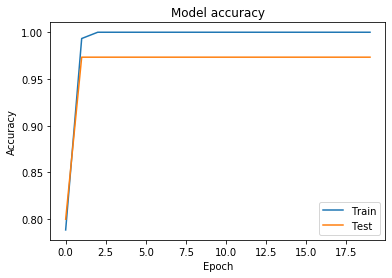

위치-나무-아래


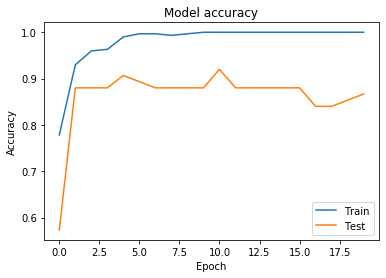

위치-나무-위


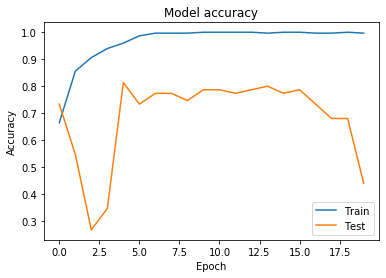

절단-나무-위


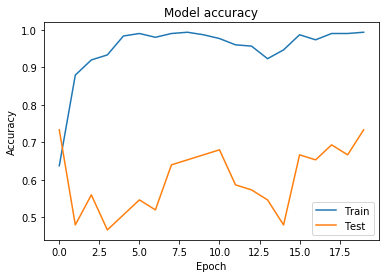

절단-나무-오른쪽


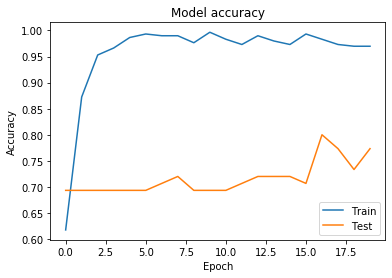

가지-아래로 늘어진 가지


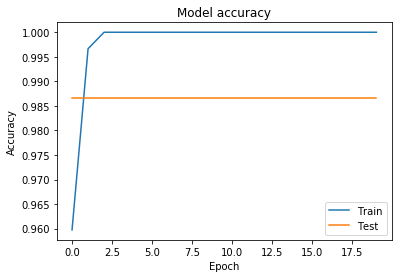

수관-공 모양


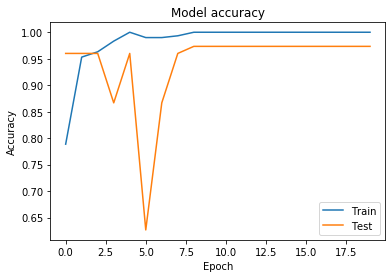

기둥-옹이구멍 안 동물


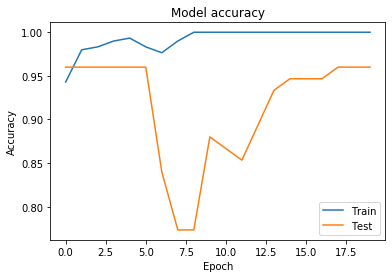

가지-부재


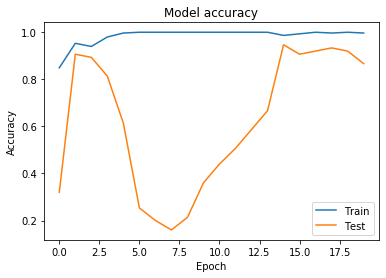

뿌리-부재2


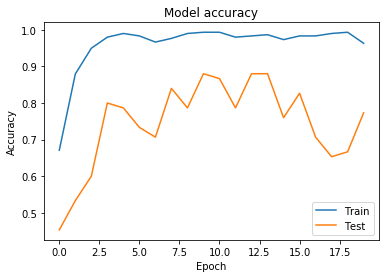

가지-옆으로 벌어짐


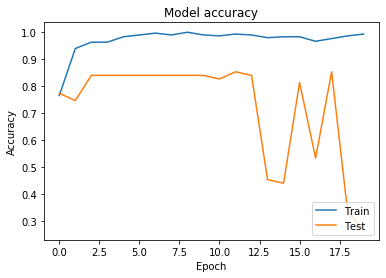

기둥-상처, 옹이구멍


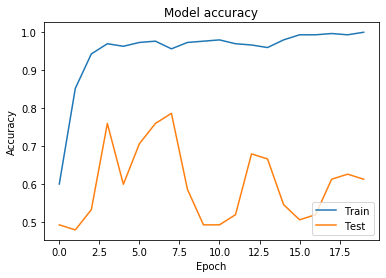

In [16]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['acc'])
        plt.plot(history[i].history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='lower right')
        plt.show()

크기-나무-크다


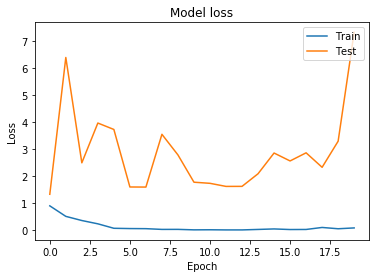

위치-나무-정중앙


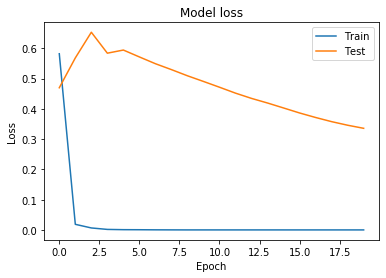

위치-나무-아래


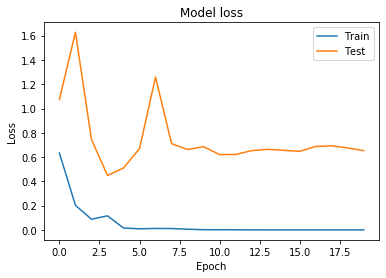

위치-나무-위


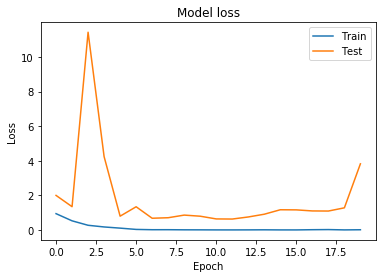

절단-나무-위


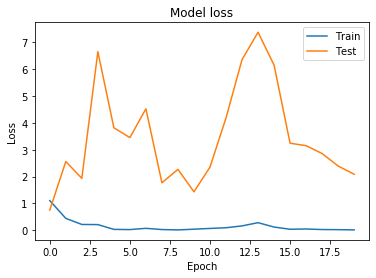

절단-나무-오른쪽


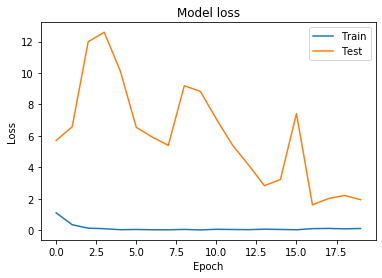

가지-아래로 늘어진 가지


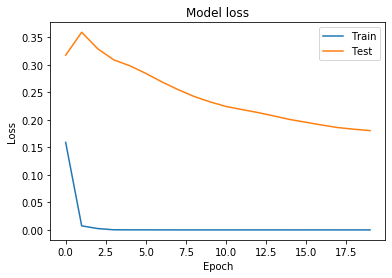

수관-공 모양


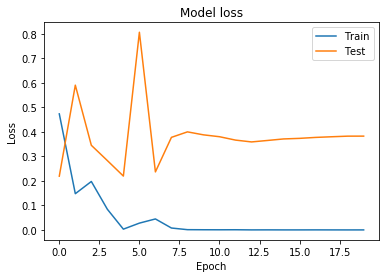

기둥-옹이구멍 안 동물


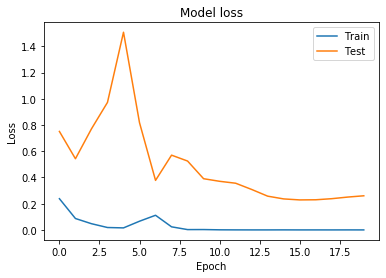

가지-부재


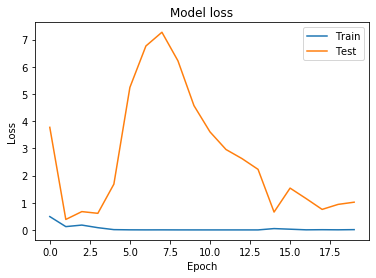

뿌리-부재2


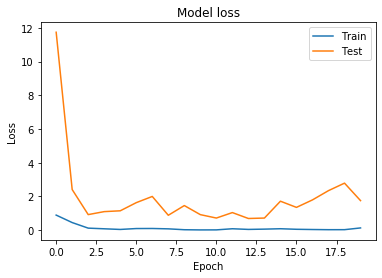

가지-옆으로 벌어짐


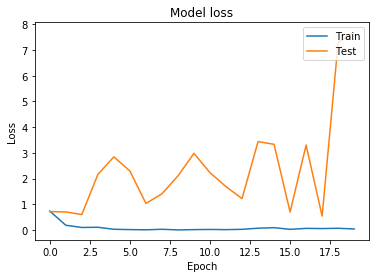

기둥-상처, 옹이구멍


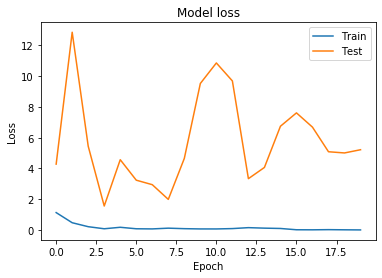

In [17]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['loss'])
        plt.plot(history[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

In [18]:
model_list = []
for num, h in enumerate(tree):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

['크기-나무-크다_mobile_model_0.56_1.3246.h5']
['위치-나무-정중앙_mobile_model_0.80_0.4698.h5', '위치-나무-정중앙_mobile_model_0.97_0.3358.h5', '위치-나무-정중앙_mobile_model_0.97_0.3459.h5', '위치-나무-정중앙_mobile_model_0.97_0.3578.h5', '위치-나무-정중앙_mobile_model_0.97_0.3715.h5', '위치-나무-정중앙_mobile_model_0.97_0.3864.h5', '위치-나무-정중앙_mobile_model_0.97_0.4030.h5', '위치-나무-정중앙_mobile_model_0.97_0.4194.h5', '위치-나무-정중앙_mobile_model_0.97_0.4346.h5', '위치-나무-정중앙_mobile_model_0.97_0.4520.h5']
['위치-나무-아래_mobile_model_0.57_1.0747.h5', '위치-나무-아래_mobile_model_0.88_0.4488.h5', '위치-나무-아래_mobile_model_0.88_0.7460.h5']
['위치-나무-위_mobile_model_0.55_1.3436.h5', '위치-나무-위_mobile_model_0.73_1.9960.h5', '위치-나무-위_mobile_model_0.77_0.6292.h5', '위치-나무-위_mobile_model_0.77_0.6754.h5', '위치-나무-위_mobile_model_0.79_0.6361.h5', '위치-나무-위_mobile_model_0.81_0.7956.h5']
['절단-나무-위_mobile_model_0.73_0.7553.h5']
['절단-나무-오른쪽_mobile_model_0.69_5.7064.h5', '절단-나무-오른쪽_mobile_model_0.72_2.8281.h5', '절단-나무-오른쪽_mobile_model_0.72_4.1622.h5', '절단-나무-오른쪽_mobile_model_0.72

In [0]:
prediction = []
for i, h in enumerate(tree):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose = 1
        ))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



12/12 [==============================] - 16s 1s/step

 7/12 [================>.............] - ETA: 9s 

In [27]:
for i, h in enumerate(tree):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    # print(submission)
    # print(len(predictions))
    # submission[h + '_class'] = predictions
    # print(submission.head(10))
    # submission.to_excel('h_' + h + '_submission.xlsx', index=False)
    # print('='*20)

376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)
376
df_test (94, 1)
prediction (376, 2)


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [0]:
def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [23]:
for h in tree:
    submission = pd.read_excel('h_'+h+'_submission.xlsx')
    print(h, ':', micro_f1(submission[h], submission[h + '_class']))

FileNotFoundError: ignored

In [0]:
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']

    for i in range(len(excel)):
        if(actual[i] == predicted[i]):
            if actual[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if actual[i] == 1:
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP

    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)

    return TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu

In [0]:
bestfeatures = ['가지-아래로 늘어진 가지',
                '위치-나무-아래',
                '위치-나무-정중앙'
                ]

In [0]:
for h in bestfeatures:
    excel = pd.read_excel('./bestfeatures/h_'+h+'_submission.xlsx')
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('Flase Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('negative_predictive_values : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print('f1 score : ', micro_f1(excel[h], excel[h+ '_class']))
    print('='*40)

In [0]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

# def f1_score(precision, recall):
#     f1 = 2 * precision * recall / (precision + recall)

    print('오차행렬\n')
    print(confusion)
    print('정확도 : {0: 4f}, 정밀도 : {1: 4f}, 재현율 : {2: 4f}, F1 Score : {2: 4f}'.format(accuracy, precision, recall, f1))

In [0]:
print(get_clf_eval(y_col, pred))

In [0]:
def plot_confusion_matrix(y_ture, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Noramlized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_ture, y_pred)
    classes = classes[unique_labels(y_ture, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arrage(cm.shape[1]),
           yticks=np.arrage(cm.shape[0]),
           xticklabels=classes, yticklabel=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()